# EDA 🔎 and 3D data 🗄️ browsing

In [1]:
!pip wheel -q https://github.com/Borda/kaggle_image-segm/archive/refs/heads/main.zip --wheel-dir frozen_packages
!rm frozen_packages/torch*
!ls -l frozen_packages | grep kaggle
!pip install -q 'kaggle-imsegm' --find-links frozen_packages --no-index

-rw-r--r-- 1 root root     9048 Apr 29 08:13 kaggle_imsegm-0.1.0.dev0-py3-none-any.whl


In [2]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df_train = pd.read_csv(path_csv)
display(df_train.head())

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [3]:
DIR_PATTERN = ("case*", "case*_day*", "scans")
all_imgs = glob.glob(os.path.join(DATASET_FOLDER, "train", *DIR_PATTERN, "*.png"))
all_imgs = [p.replace(DATASET_FOLDER, "") for p in all_imgs]

print(f"images: {len(all_imgs)}")
print(f"annotated: {len(df_train['id'].unique())}")

images: 38496
annotated: 38496


## 🔎 Explore and enrich dataset

Take the input train table and parse some additiona informations

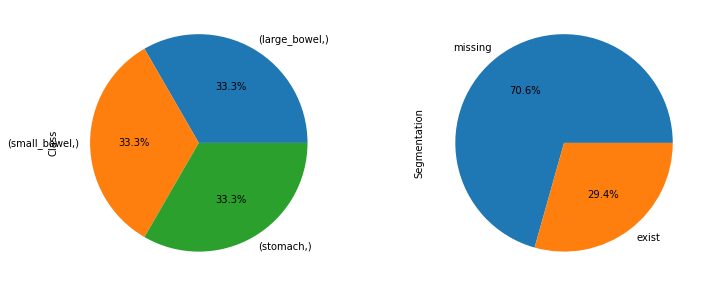

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

_= df_train[["class"]].value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%', ylabel="Class")

count_miss_segm = df_train["segmentation"].isna().sum()
_= pd.Series({
    "missing": count_miss_segm,
    "exist": len(df_train) - count_miss_segm,
}).plot.pie(ax=axes[1], autopct='%1.1f%%', ylabel="Segmentation")

Add linking to the images in dataset folder

In [5]:
def extract_details(id_):
    id_fields = id_.split("_")
    case = id_fields[0].replace("case", "")
    day = id_fields[1].replace("day", "")
    slice_id = id_fields[3]
    img_dir = os.path.join(DATASET_FOLDER, "train",
                           f"case{case}", f"case{case}_day{day}", "scans")
    imgs = glob.glob(os.path.join(img_dir, f"slice_{slice_id}_*.png"))
    assert len(imgs) == 1
    img_path = imgs[0].replace(DATASET_FOLDER + "/", "")
    img = os.path.basename(img_path)
    # slice_0001_266_266_1.50_1.50.png
    im_fields = img.split("_")
    return {
        "Case": int(case),
        "Day": int(day),
        "Slice": slice_id,
        "image": img,
        "image_path": img_path, 
        "height": int(im_fields[2]),
        "width": int(im_fields[3]),
    }

In [6]:
df_train[['Case','Day','Slice', 'image', 'image_path', 'height', 'width']] = \
    df_train['id'].apply(lambda x: pd.Series(extract_details(x)))
display(df_train.head())

,id,class,segmentation,Case,Day,Slice,image,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266


Compare timeseries and stack sizes

In [7]:
from tqdm.auto import tqdm

train_overview = []
for (case, day), dfg in tqdm(df_train.groupby(["Case", "Day"])):
    train_overview.append({"Day": int(day), "Case": int(case), "Slices": len(dfg)})
df_train_overview = pd.DataFrame(train_overview)
display(df_train_overview.head())

  0%|          | 0/274 [00:00<?, ?it/s]

,Day,Case,Slices
0,1,2,432
1,2,2,432
2,3,2,432
3,4,2,432
4,5,2,432


In [8]:
train_ = []
for id_, dfg in tqdm(df_train.groupby("id")):
    row = dict(dfg.iloc[0])
    del row["class"]
    del row["segmentation"]
    for _, (cls, segm) in dfg[["class", "segmentation"]].iterrows():
        row[cls] = segm
    train_.append(row)
df_train_aggr = pd.DataFrame(train_)
display(df_train_aggr.head())

  0%|          | 0/38496 [00:00<?, ?it/s]

,id,Case,Day,Slice,image,image_path,height,width,large_bowel,small_bowel,stomach
0,case101_day20_slice_0001,101,20,0001,slice_0001_266_266_1.50_1.50.png,train/case101/case101_day20/scans/slice_0001_2...,266,266,NaN,NaN,NaN
1,case101_day20_slice_0002,101,20,0002,slice_0002_266_266_1.50_1.50.png,train/case101/case101_day20/scans/slice_0002_2...,266,266,NaN,NaN,NaN
2,case101_day20_slice_0003,101,20,0003,slice_0003_266_266_1.50_1.50.png,train/case101/case101_day20/scans/slice_0003_2...,266,266,NaN,NaN,NaN
3,case101_day20_slice_0004,101,20,0004,slice_0004_266_266_1.50_1.50.png,train/case101/case101_day20/scans/slice_0004_2...,266,266,NaN,NaN,NaN
4,case101_day20_slice_0005,101,20,0005,slice_0005_266_266_1.50_1.50.png,train/case101/case101_day20/scans/slice_0005_2...,266,266,NaN,NaN,NaN


Text(0.5, 0, 'sampled days')

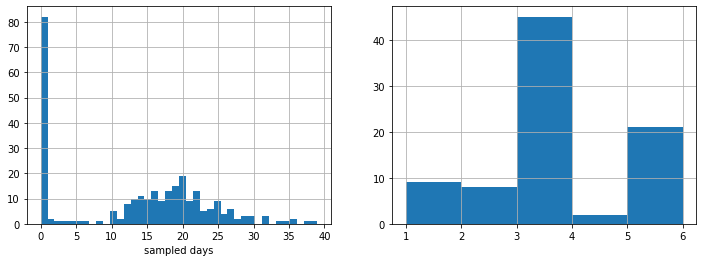

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
df_uq = df_train_aggr.drop_duplicates(["Case","Day"])
df_uq["Day"].hist(ax=axes[0], bins=40)
axes[0].set_xlabel("day indexes")
df_uq["Case"].value_counts().hist(ax=axes[1], bins=5)
axes[0].set_xlabel("sampled days")

<AxesSubplot:ylabel='None'>

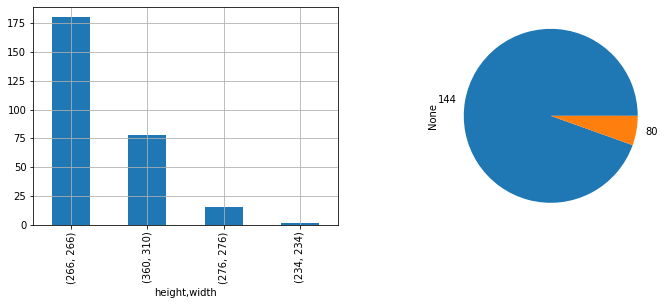

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
df_hw = df_train_aggr.drop_duplicates(["Case","Day"])[["height", "width"]]
df_hw.value_counts().plot.bar(ax=axes[0], grid=True)
df_train_aggr.groupby(["Case","Day"]).size().value_counts().plot.pie(ax=axes[1])

Text(0, 0.5, 'nb slices')

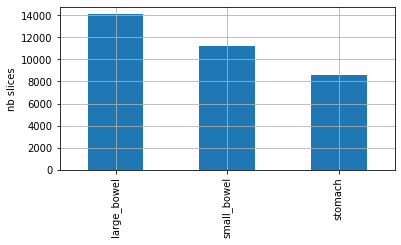

In [11]:
cls_segm = {k: len(df_train_aggr) - df_train_aggr[k].isna().sum()
            for k in ("large_bowel", "small_bowel", "stomach")}
ax = pd.Series(cls_segm).plot.bar(grid=True, figsize=(6, 3))
ax.set_ylabel("nb slices")

## Browse the 3D image

In [12]:
import numpy as np
from PIL import Image

def load_image_volume(img_dir, quant=0.01):
    imgs = sorted(glob.glob(os.path.join(img_dir, f"*.png")))
    imgs = [np.array(Image.open(p)).tolist() for p in imgs]
    # print([np.max(im) for im in imgs])
    vol = np.array(imgs)
    if quant:
        q_low, q_high = np.percentile(vol, [quant * 100, (1 - quant) * 100])
        vol = np.clip(vol, q_low, q_high)
    v_min, v_max = np.min(vol), np.max(vol)
    vol = (vol - v_min) / (v_max - v_min)
    vol = (vol * 255).astype(np.uint8)
    return vol

In [13]:
from kaggle_imsegm.mask import rle_decode

def create_organs_segm(df_vol, vol_shape):
    df_vol = df_vol.replace(np.nan, '')
    segm = np.zeros(vol_shape, dtype=np.uint8)
    lbs = sorted(df_vol["class"].unique())
    for idx_, dfg in df_vol.groupby("Slice"):
        idx = int(idx_) - 1
        mask = segm[idx, :, :]
        for _, (lb, rle) in dfg[["class", "segmentation"]].iterrows():
            lb = lbs.index(lb) + 1
            if not rle:
                continue
            mask = rle_decode(rle, img=mask, label=lb)
        segm[idx, :, :] = mask
        # plt.figure(); plt.imshow(mask)
    return segm

In [14]:
CASE = 114
DAY = 15
IMAGE_FOLDER = os.path.join(
    DATASET_FOLDER, "train", f"case{CASE}", f"case{CASE}_day{DAY}", "scans")

vol = load_image_volume(img_dir=IMAGE_FOLDER)
print(vol.shape)

df_ = df_train[(df_train["Case"] == CASE) & (df_train["Day"] == DAY)]
segm = create_organs_segm(df_vol=df_, vol_shape=vol.shape)
print(segm.shape)

(144, 310, 360)
(144, 310, 360)


In [15]:
from ipywidgets import interact, IntSlider
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from skimage import color


def _draw_line(ax, coords, clr='g'):
    line = Path(coords, [Path.MOVETO, Path.LINETO])
    pp = PathPatch(line, linewidth=3, edgecolor=clr, facecolor='none')
    ax.add_patch(pp)

def _set_axes_labels(ax, axes_x, axes_y):
    ax.set_xlabel(axes_x)
    ax.set_ylabel(axes_y)
    ax.set_aspect('equal', 'box')

_rec_prop = dict(linewidth=5, facecolor='none')

def show_volume(vol, segm, z, y, x, fig_size=(9, 9)):
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=fig_size)
    v_z, v_y, v_x = vol.shape
    # axarr[0, 0].imshow(vol[x, :, :], cmap="gray", vmin=0, vmax=255)
    # axarr[0, 1].imshow(vol[:, :, z], cmap="gray", vmin=0, vmax=255)
    # axarr[1, 0].imshow(vol[:, y, :], cmap="gray", vmin=0, vmax=255)
    axarr[0, 0].imshow(color.label2rgb(segm[z, :, :], vol[z, :, :]))
    axarr[0, 0].add_patch(Rectangle((-1, -1), v_x, v_y, edgecolor='r', **_rec_prop))
    _draw_line(axarr[0, 0], [(x, 0), (x, v_y)], "g")
    _draw_line(axarr[0, 0], [(0, y), (v_x, y)], "b")
    _set_axes_labels(axarr[0, 0], "X", "Y")
    axarr[0, 1].imshow(color.label2rgb(segm[:, :, x].T, vol[:, :, x].T))
    axarr[0, 1].add_patch(Rectangle((-1, -1), v_z, v_y, edgecolor='g', **_rec_prop))
    _draw_line(axarr[0, 1], [(z, 0), (z, v_y)], "r")
    _draw_line(axarr[0, 1], [(0, y), (v_x, y)], "b")
    _set_axes_labels(axarr[0, 1], "Z", "Y")
    axarr[1, 0].imshow(color.label2rgb(segm[:, y, :], vol[:, y, :]))
    axarr[1, 0].add_patch(Rectangle((-1, -1), v_x, v_z, edgecolor='b', **_rec_prop))
    _draw_line(axarr[1, 0], [(0, z), (v_x, z)], "r")
    _draw_line(axarr[1, 0], [(x, 0), (x, v_y)], "g")
    _set_axes_labels(axarr[1, 0], "X", "Z")
    axarr[1, 1].set_axis_off()
    fig.tight_layout()


def interactive_show(volume):
    vol_shape = volume.shape
    interact(
        lambda x, y, z: plt.show(show_volume(volume, segm, z, y, x)),
        z=IntSlider(min=0, max=vol_shape[0], step=5, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1], step=5, value=int(vol_shape[1] / 2)),
        x=IntSlider(min=0, max=vol_shape[2], step=5, value=int(vol_shape[2] / 2)),
    )

In [16]:
interactive_show(vol)

interactive(children=(IntSlider(value=180, description='x', max=360, step=5), IntSlider(value=155, description…